In [835]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy as dc

# Set random seed for reproducibility
seed = 13
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using CUDA

In [836]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# **Set Up Functions**

## **Preprocess Data**

In [837]:
# Define a function to preprocess the data
def preprocess_data(data, window_size=10):
    # Visualize the original data
    visualize_data(data)

    # Log transform and difference the data
    data = log_difference_transform(data)

    # Moving average
    data = moving_average(data, window_size)

    visualize_data(data)

    # Shift the target column by 1 to align with the next day's data
    data['Target'] = data['Close'].shift(-1)

    # Remove NaN values
    data.dropna(inplace=True)

    return data

In [838]:
# Define a function to visualize the original data
def visualize_data(data):
    fig, axs = plt.subplots(6, 1, figsize=(12, 15), sharex=True)
    axs[0].plot(data['Date'], data['Open'])
    axs[0].set_ylabel('Open')

    axs[1].plot(data['Date'], data['High'])
    axs[1].set_ylabel('High')

    axs[2].plot(data['Date'], data['Low'])
    axs[2].set_ylabel('Low')

    axs[3].plot(data['Date'], data['Close'])
    axs[3].set_ylabel('Close')

    axs[4].plot(data['Date'], data['Adj Close'])
    axs[4].set_ylabel('Adj Close')

    axs[5].plot(data['Date'], data['Volume'])
    axs[5].set_ylabel('Volume')

    plt.show()

In [839]:
# Define a function to log-transform and difference the data
def log_difference_transform(data):
    data['Open'] = np.log(data['Open'])
    data['High'] = np.log(data['High'])
    data['Low'] = np.log(data['Low'])
    data['Close'] = np.log(data['Close'])
    data['Adj Close'] = np.log(data['Adj Close'])
    data['Volume'] = np.log(data['Volume'] + 1)

    data['Open'] = data['Open'].diff()
    data['High'] = data['High'].diff()
    data['Low'] = data['Low'].diff()
    data['Close'] = data['Close'].diff()
    data['Adj Close'] = data['Adj Close'].diff()
    data['Volume'] = data['Volume'].diff()

    data.fillna(data.mean(), inplace=True)

    return data

In [840]:
# Define a function to apply moving average to the data
def moving_average(data, window_size=10):
    columns_to_smooth = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in columns_to_smooth:
        data[col] = data[col].rolling(window=window_size).mean()
    data.dropna(inplace=True)
    return data

## **Prepare Data**

In [841]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [842]:
# Define a function to prepare the dataset for training
def prepare_dataset(data, lookback=10):
    shifted_df = prepare_dataframe(data, lookback)
    shifted_df_as_np = shifted_df.to_numpy()

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]

    # Reverse X to ensure the correct order for time series
    X = dc(np.flip(X, axis=1))

    # Split the data into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

    # Reshape the data for LSTM input
    X_train = X_train.reshape((-1, lookback + 6, 1))
    X_val = X_val.reshape((-1, lookback + 6, 1))
    X_test = X_test.reshape((-1, lookback + 6, 1))

    y_train = y_train.reshape((-1, 1))
    y_val = y_val.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()
    X_val = torch.tensor(X_val).float()
    y_val = torch.tensor(y_val).float()
    X_test = torch.tensor(X_test).float()
    y_test = torch.tensor(y_test).float()

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

In [843]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [844]:
# Define a function to create a PyTorch dataset and data loader
def create_data_loader(X, y, batch_size=16, shuffle=False):
    dataset = TimeSeriesDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

## **Build LSTM Model**

In [845]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

## **Train**

In [846]:
# Define a function to train and validate the model
def train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train(True)  # Set the model to training mode
        print(f'Epoch: {epoch + 1}')
        running_train_loss = 0.0
        running_val_loss = 0.0

        # Training loop
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            output = model(x_batch)
            train_loss = loss_function(output, y_batch)
            running_train_loss += train_loss.item()

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if batch_index % 100 == 99:  # Print every 100 batches
                avg_train_loss_across_batches = running_train_loss / 100
                print('Batch {0}, Train Loss: {1:.3f}'.format(batch_index + 1, avg_train_loss_across_batches))
                running_train_loss = 0.0

        # Validation loop
        model.train(False)  # Set the model to evaluation mode
        for batch_index, batch in enumerate(val_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            with torch.no_grad():
                output = model(x_batch)
                val_loss = loss_function(output, y_batch)
                running_val_loss += val_loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        avg_val_loss = running_val_loss / len(val_loader)

        print(f'Train Loss: {avg_train_loss:.3f}, Val Loss: {avg_val_loss:.3f}')
        print('***************************************************')
        print()

        # Plot training and validation losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    # Plot training and validation losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return train_losses, val_losses

## **Evaluate**

In [847]:
def evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test):
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Test Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

    # Inverse transform the predictions and true values
    predicted = model(X_test.to(device)).to('cpu').detach().numpy()
    test_predictions = predicted.flatten()

    # Inverse transform predictions
    dummies_pred = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
    dummies_pred[:, 0] = test_predictions
    dummies_pred = scaler.inverse_transform(dummies_pred)
    test_predictions = dummies_pred[:, 0]

    # Reverse differencing
    test_predictions = np.cumsum(test_predictions)

    # Inverse log transformation
    test_predictions = np.exp(test_predictions)

    # Inverse transform true values
    dummies_true = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
    dummies_true[:, 0] = y_test.flatten()
    dummies_true = scaler.inverse_transform(dummies_true)
    new_y_test = dummies_true[:, 0]

    # Reverse differencing
    new_y_test = np.cumsum(new_y_test)

    # Inverse log transformation
    new_y_test = np.exp(new_y_test)

    plt.plot(new_y_test, label='Actual Close')
    plt.plot(test_predictions, label='Predicted Close')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

    # Calculate and print RMSE and MAE for the test set
    print("Test Set Metrics:")
    calculate_metrics(new_y_test, test_predictions)

    return new_y_test, test_predictions

# Define a function to calculate RMSE and MAE
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    return rmse, mae

In [848]:
def plot_losses(train_losses_list, val_losses_list, titles):
    plt.figure(figsize=(10, 6))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors

    for i in range(len(train_losses_list)):
        train_losses = train_losses_list[i]
        val_losses = val_losses_list[i]
        title = titles[i]
        color = colors[i % len(colors)]  # Pick a color from the list

        plt.plot(train_losses, label=f'{title} Training Loss', color=color)
        plt.plot(val_losses, label=f'{title} Validation Loss', linestyle='dashed', color=color)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(true_values, pred_lists, titles):
    plt.figure(figsize=(10, 6))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors

    plt.plot(true_values, label='Actual Close', linestyle='dashed')

    for i in range(len(pred_lists)):
        predictions = pred_lists[i]
        title = titles[i]
        color = colors[i % len(colors)]  # Pick a color from the list

        plt.plot(predictions, label=f'{title} Predicted Close', color=color)

    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title('Actual vs Predicted Close Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

# **Tune Hyperparameters**

## **Experiment with different Lookbacks**

## **Experiment with different Stock Datasets**

### **Dataset: Amazon**

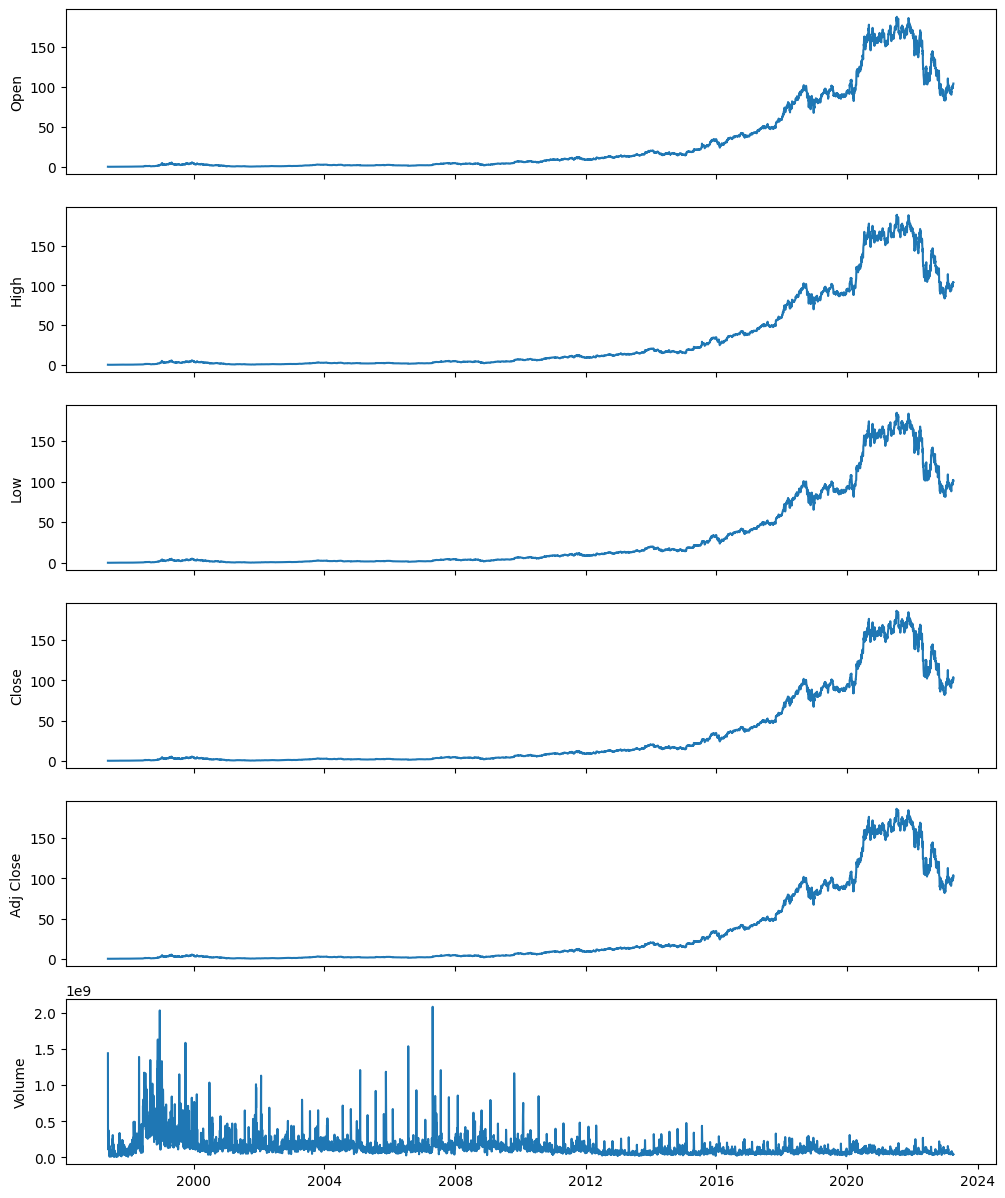

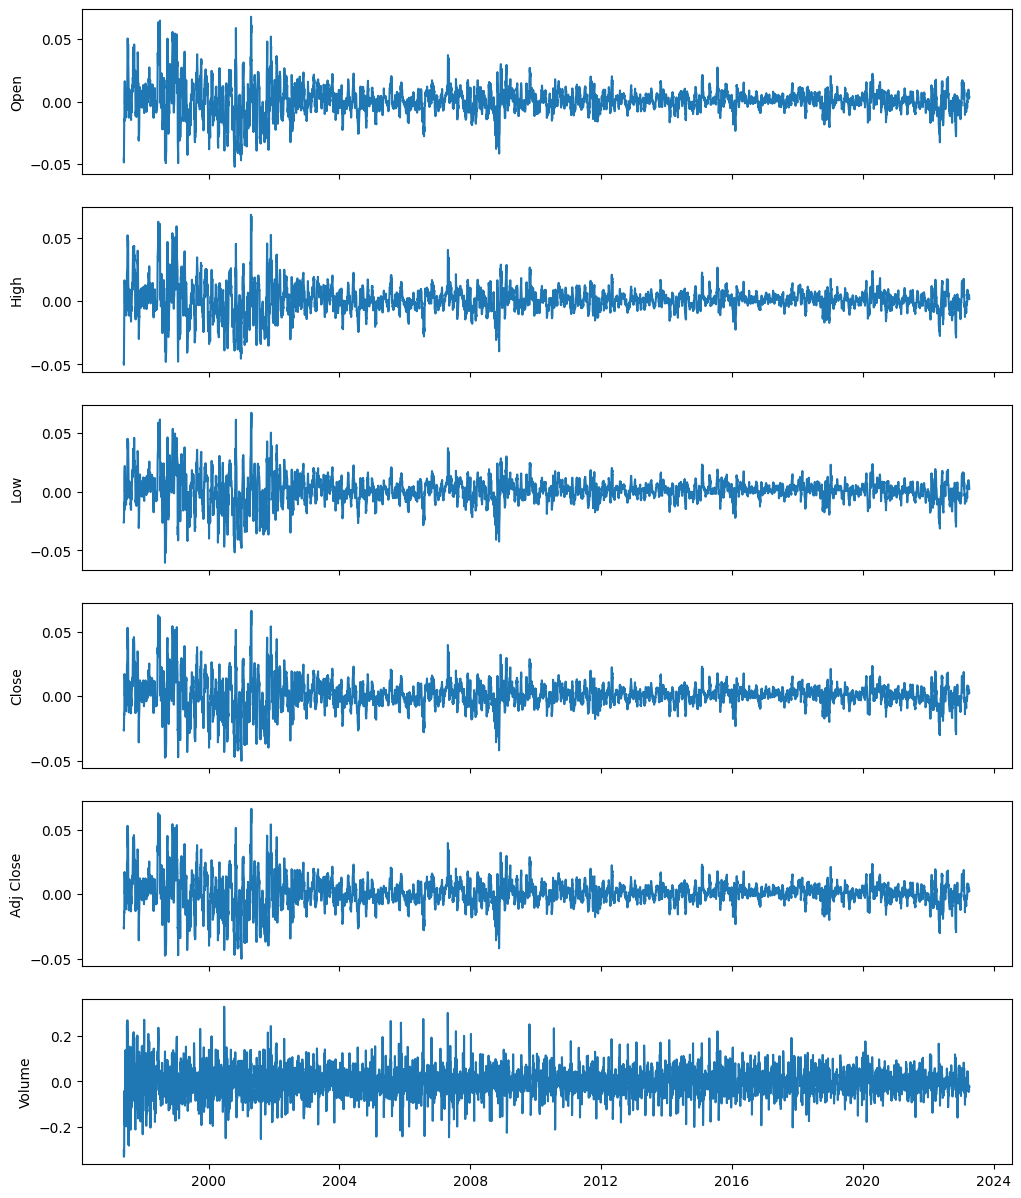

Experimenting with lookback = 10
Epoch: 1
Batch 100, Train Loss: 0.277
Batch 200, Train Loss: 0.046
Train Loss: 0.001, Val Loss: 0.005
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.037
Batch 200, Train Loss: 0.005
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.015
Batch 200, Train Loss: 0.003
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.012
Batch 200, Train Loss: 0.003
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.011
Batch 200, Train Loss: 0.003
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.011
Batch 200, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Train Loss: 0.010

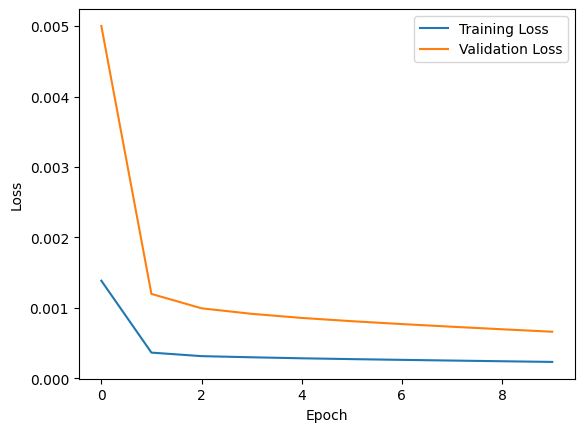

Test Loss: 0.001
***************************************************



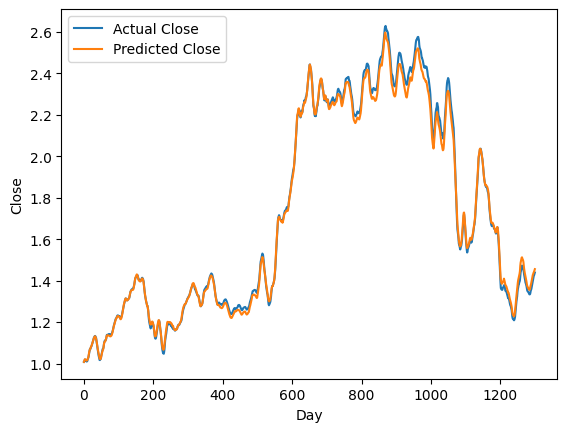

Test Set Metrics:
RMSE: 0.0258, MAE: 0.0187
Experimenting with lookback = 20
Epoch: 1
Batch 100, Train Loss: 0.112
Batch 200, Train Loss: 0.019
Train Loss: 0.001, Val Loss: 0.005
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.033
Batch 200, Train Loss: 0.003
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.012
Batch 200, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.010
Batch 200, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.010
Batch 200, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.009
Batch 200, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
**********************************************

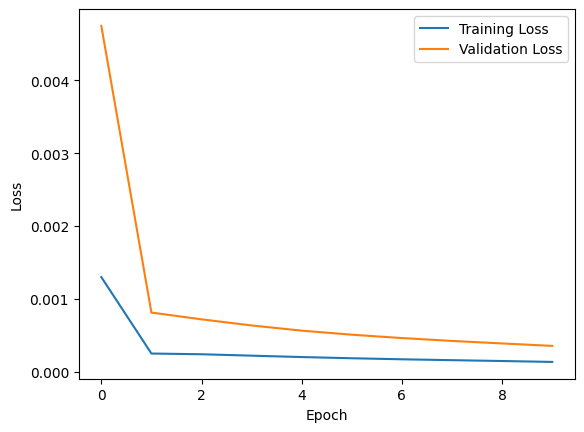

Test Loss: 0.001
***************************************************



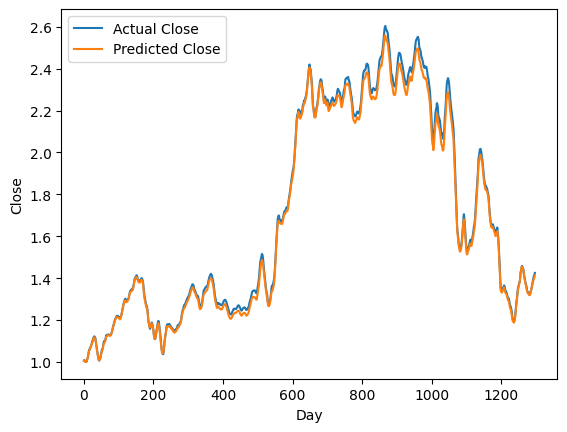

Test Set Metrics:
RMSE: 0.0262, MAE: 0.0206
Experimenting with lookback = 30
Epoch: 1
Batch 100, Train Loss: 0.130
Batch 200, Train Loss: 0.024
Train Loss: 0.002, Val Loss: 0.007
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.062
Batch 200, Train Loss: 0.010
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.018
Batch 200, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.011
Batch 200, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.010
Batch 200, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.010
Batch 200, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
**********************************************

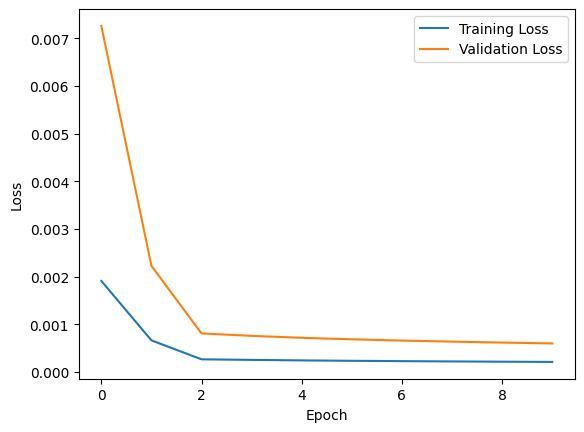

Test Loss: 0.001
***************************************************



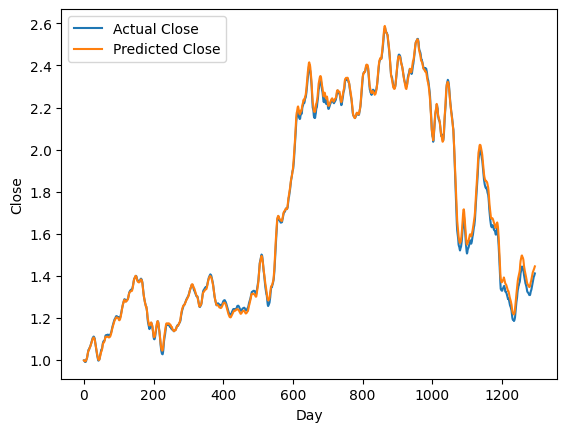

Test Set Metrics:
RMSE: 0.0183, MAE: 0.0132


In [849]:
# Main function to experiment with different lookback values
def experiment_with_lookback(data_path, lookback_values, num_epochs=10, batch_size=16, learning_rate=0.001):
    data = pd.read_csv(data_path)
    data['Date'] = pd.to_datetime(data['Date'])
    preprocessed_data = preprocess_data(data)

    for lookback in lookback_values:
        print(f"Experimenting with lookback = {lookback}")
        X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(preprocessed_data, lookback)
        train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
        val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
        test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
        model = LSTM(1, 4, 1)
        model.to(device)

        learning_rate = 0.001
        num_epochs = 10
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
        evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

data_path = 'AMZN.csv'
lookback_values = [10, 20, 30]  # Experiment with different lookback values
experiment_with_lookback(data_path, lookback_values)

### **Dataset: Google**

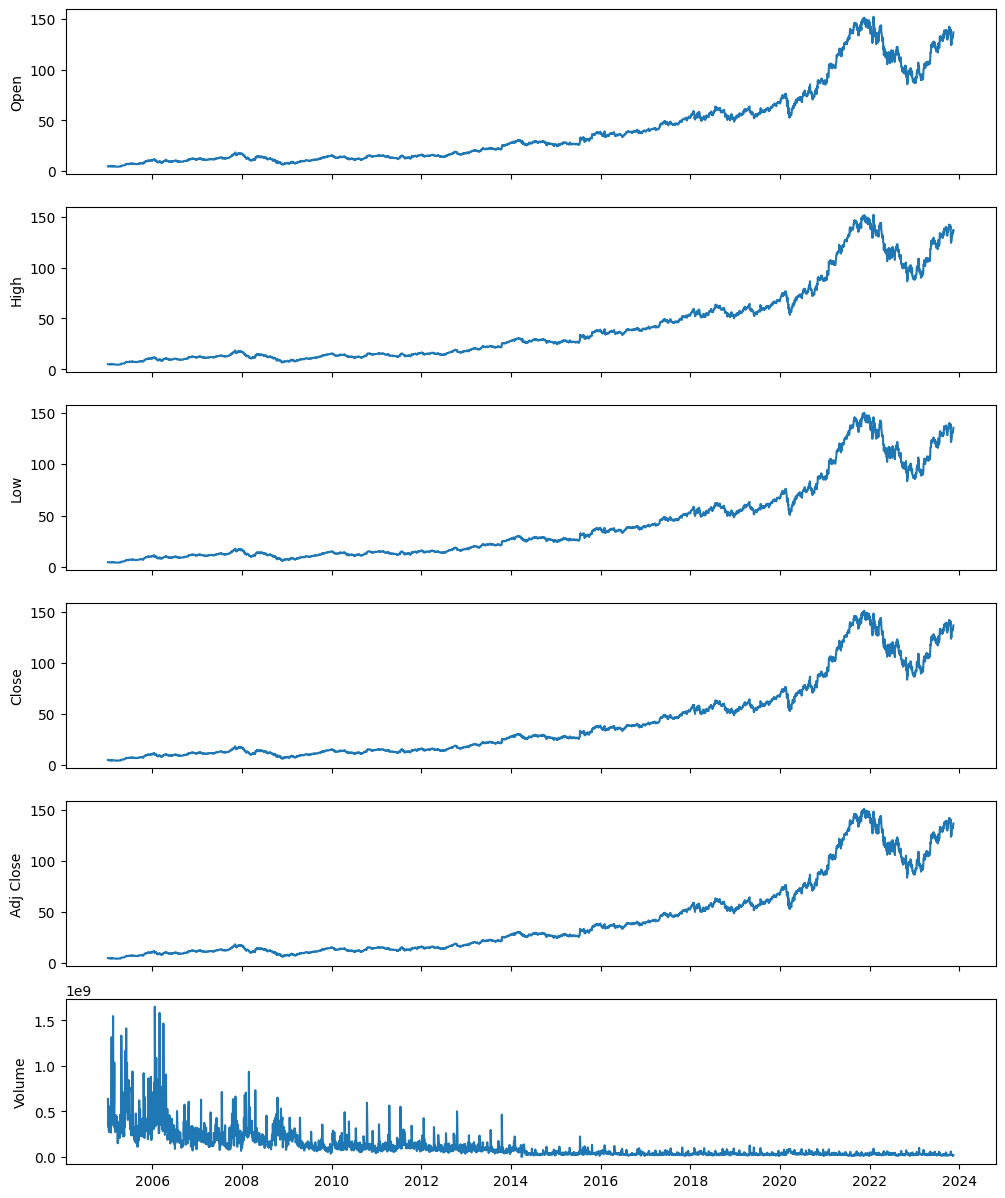

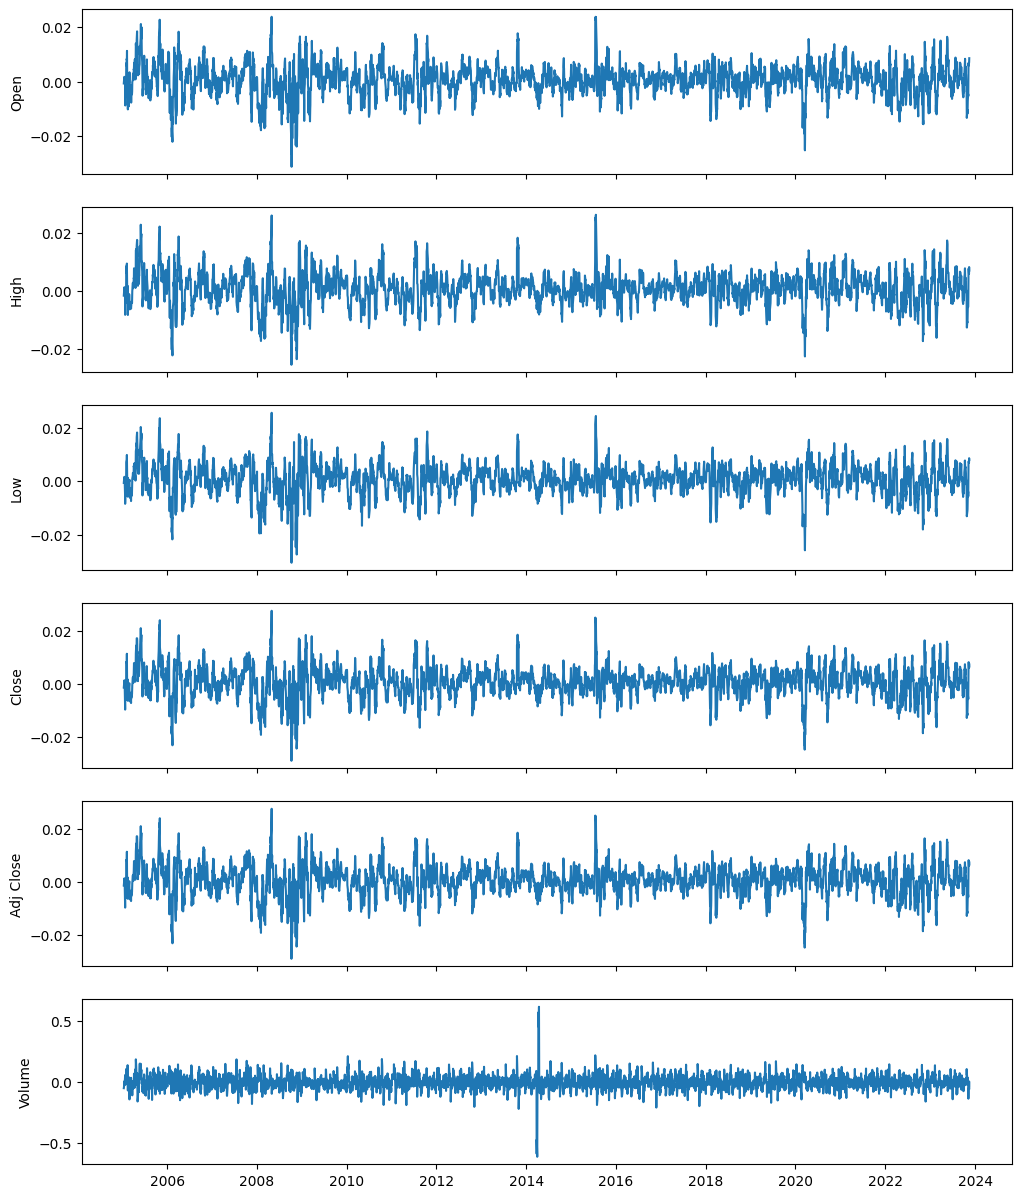

Experimenting with lookback = 10
Epoch: 1
Batch 100, Train Loss: 0.087
Train Loss: 0.013, Val Loss: 0.018
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.043
Train Loss: 0.005, Val Loss: 0.004
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.012
Train Loss: 0.002, Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.007
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.006
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.005
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Train Loss: 0.005
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 8
Batch 100, Train Loss: 0.005
Train Loss: 0.001, Val Loss: 0.002
************

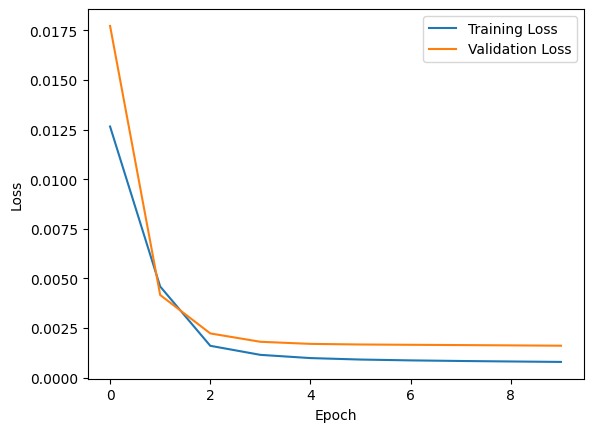

Test Loss: 0.003
***************************************************



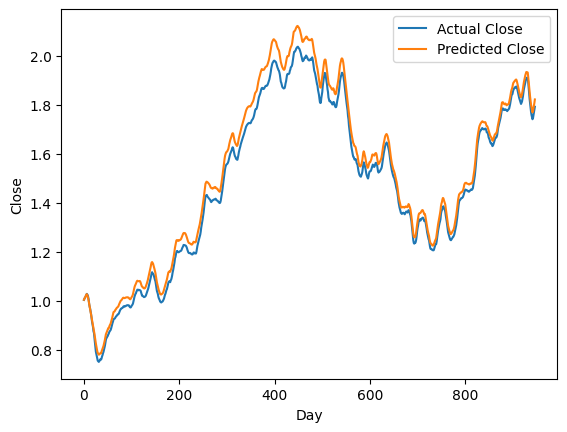

Test Set Metrics:
RMSE: 0.0474, MAE: 0.0430
Experimenting with lookback = 20
Epoch: 1
Batch 100, Train Loss: 0.098
Train Loss: 0.010, Val Loss: 0.012
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.027
Train Loss: 0.003, Val Loss: 0.004
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.008
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.005
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.004
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.004
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Train Loss: 0.004
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 8
Batch 100, Train Loss: 0.004
Tra

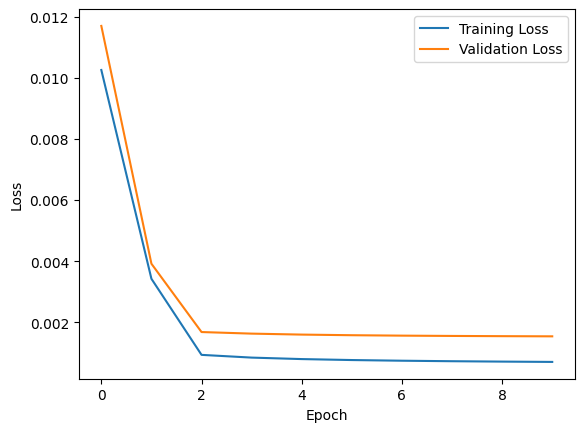

Test Loss: 0.003
***************************************************



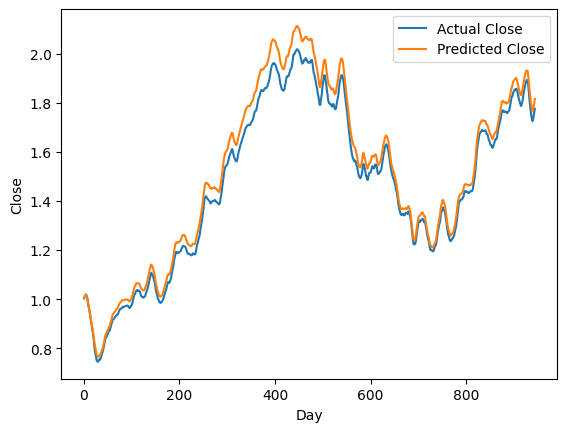

Test Set Metrics:
RMSE: 0.0516, MAE: 0.0457
Experimenting with lookback = 30
Epoch: 1
Batch 100, Train Loss: 0.052
Train Loss: 0.010, Val Loss: 0.014
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.032
Train Loss: 0.003, Val Loss: 0.003
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.007
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.005
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.004
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.004
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Train Loss: 0.004
Train Loss: 0.001, Val Loss: 0.002
***************************************************

Epoch: 8
Batch 100, Train Loss: 0.004
Tra

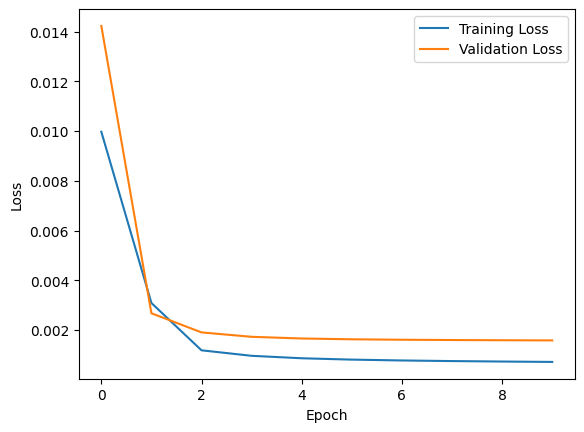

Test Loss: 0.003
***************************************************



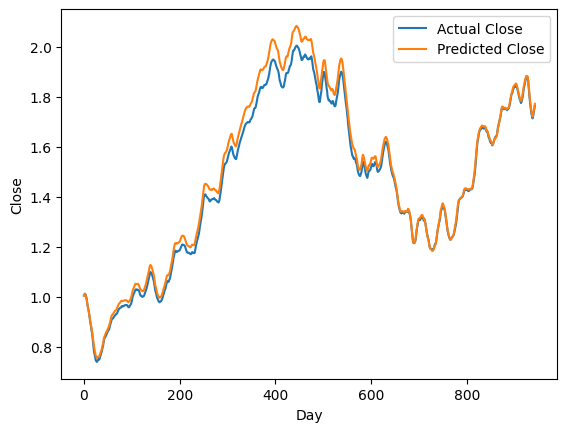

Test Set Metrics:
RMSE: 0.0384, MAE: 0.0296


In [850]:
def experiment_with_lookback(data_path, lookback_values, num_epochs=10, batch_size=16, learning_rate=0.001):
    data = pd.read_csv(data_path)
    data['Date'] = pd.to_datetime(data['Date'])
    preprocessed_data = preprocess_data(data)

    for lookback in lookback_values:
        print(f"Experimenting with lookback = {lookback}")
        X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(preprocessed_data, lookback)
        train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
        val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
        test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
        model = LSTM(1, 4, 1)
        model.to(device)

        learning_rate = 0.001
        num_epochs = 10
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
        evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

data_path = 'GOOG.csv'
lookback_values = [10, 20, 30]  # Experiment with different lookback values
experiment_with_lookback(data_path, lookback_values)

## **Experiment with different Hidden Sizes**

### **Dataset: Commonwealth Bank**

### **Hidden Size: 4**

### **Numbers of Layers: 1**

### **Optimizer: Adam**

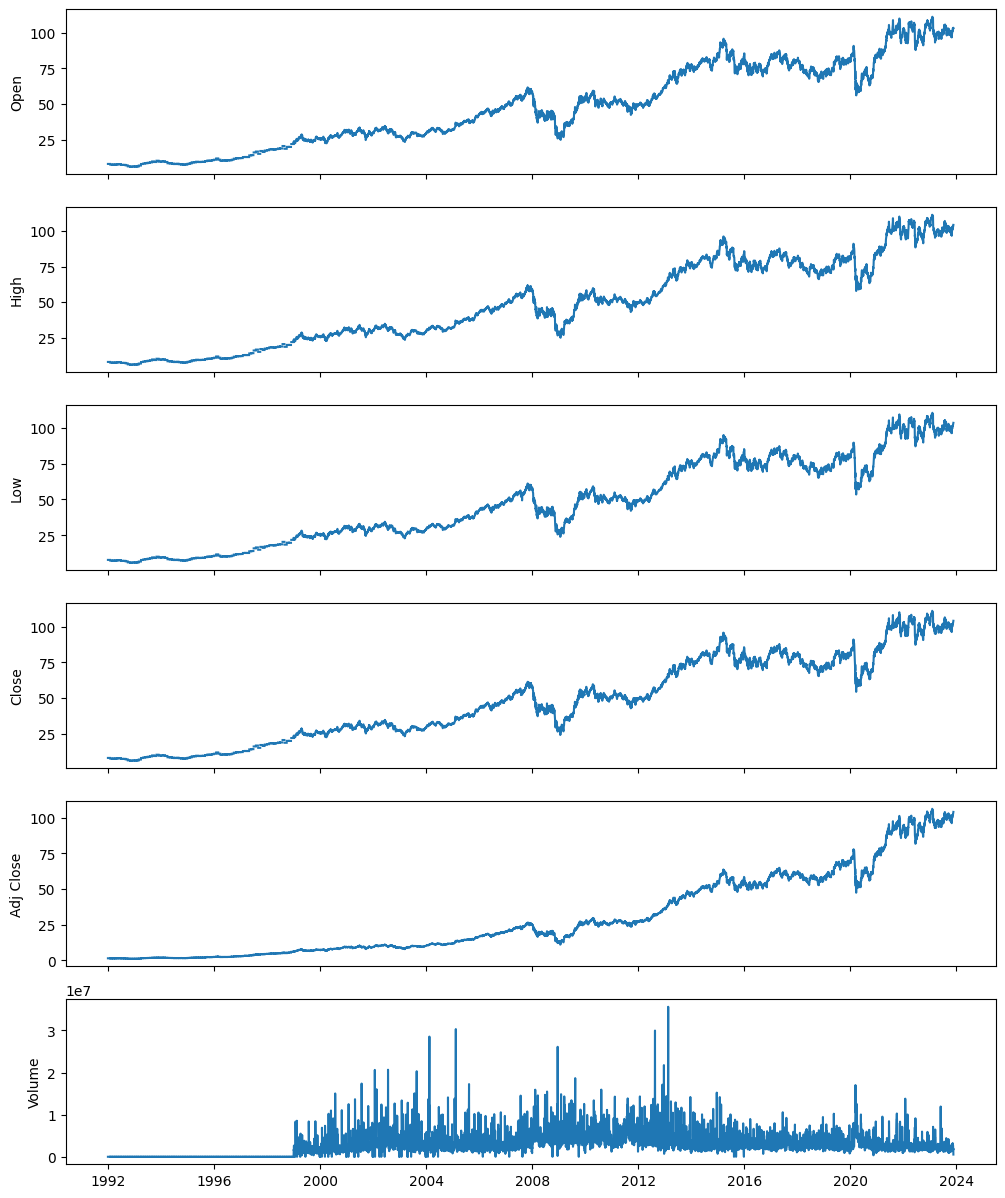

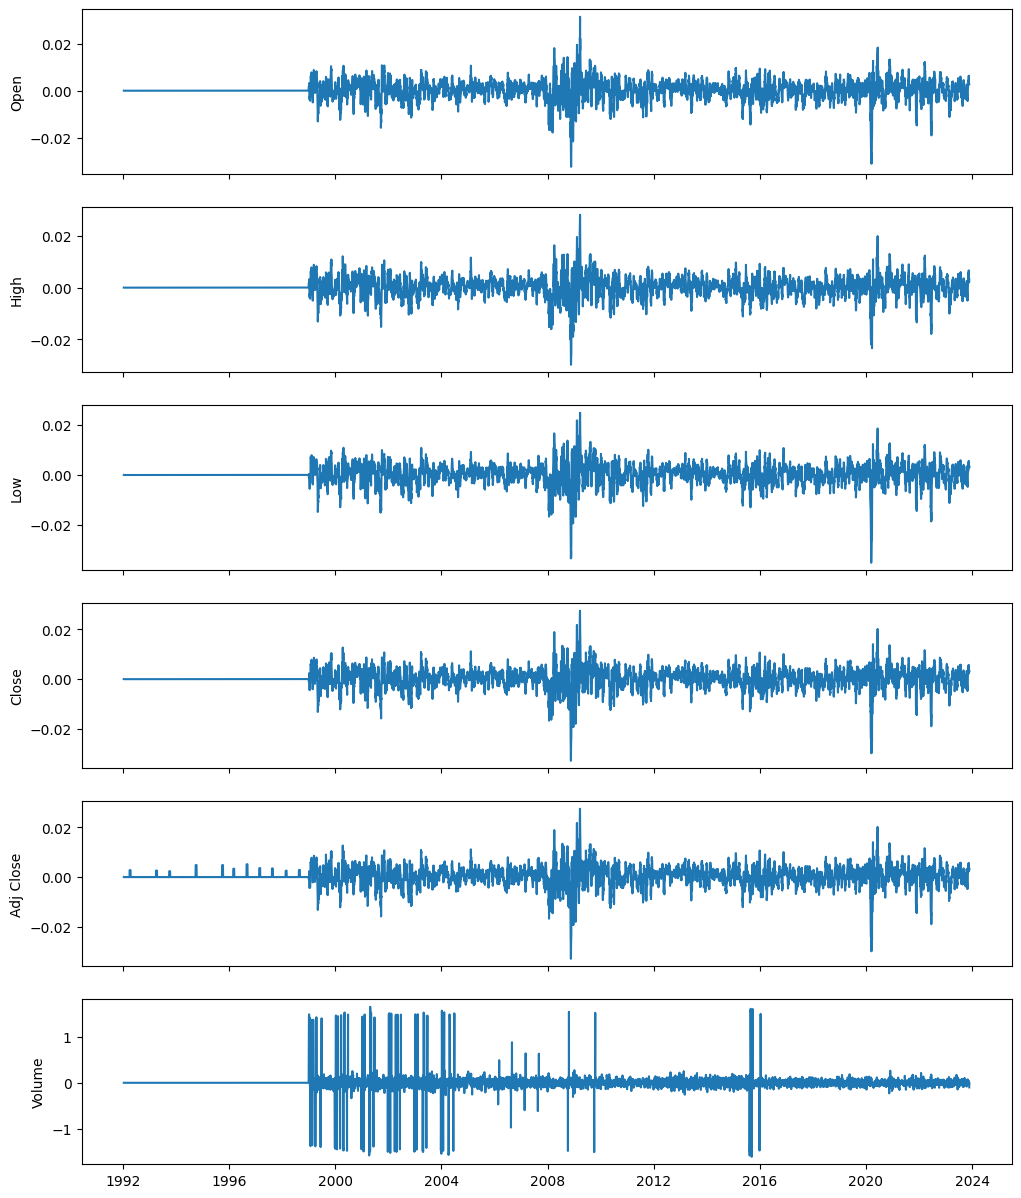

Epoch: 1
Batch 100, Train Loss: 0.066
Batch 200, Train Loss: 0.018
Batch 300, Train Loss: 0.029
Train Loss: 0.001, Val Loss: 0.011
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.013
Batch 300, Train Loss: 0.021
Train Loss: 0.001, Val Loss: 0.007
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.007
Batch 300, Train Loss: 0.008
Train Loss: 0.000, Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.002
Batch 300, Train Loss: 0.005
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.002
Batch 300, Train Loss: 0.004
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Tr

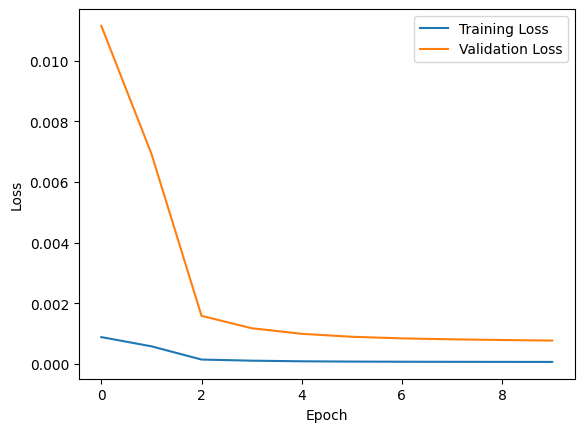

Test Loss: 0.001
***************************************************



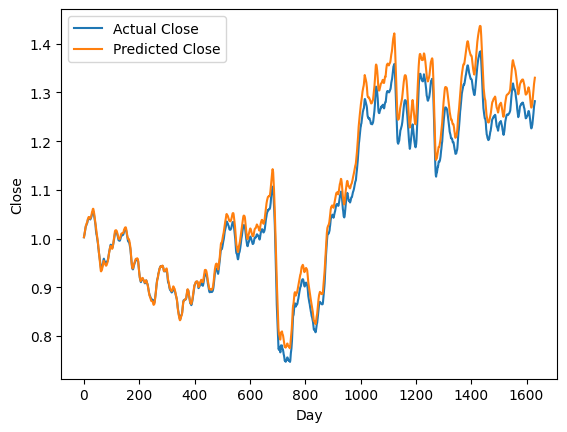

Test Set Metrics:
RMSE: 0.0311, MAE: 0.0254


In [851]:
data_path = 'CBA.AX.csv'
CBA_data = pd.read_csv(data_path)
CBA_data['Date'] = pd.to_datetime(CBA_data['Date'])
CBA_preprocessed_data = preprocess_data(CBA_data)

def experiment_with_hyperparameters(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = LSTM(1, 4, 1)
    model.to(device)

    learning_rate = 0.001
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    hidden4_train_losses, hidden4_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    hidden4_new_y_test, hidden4_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return hidden4_train_losses, hidden4_val_losses, hidden4_new_y_test, hidden4_test_predictions

hidden4_train_losses, hidden4_val_losses, hidden4_new_y_test, hidden4_test_predictions = experiment_with_hyperparameters()

### **Hidden Size: 8**

Epoch: 1
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.010
Batch 300, Train Loss: 0.005
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Tr

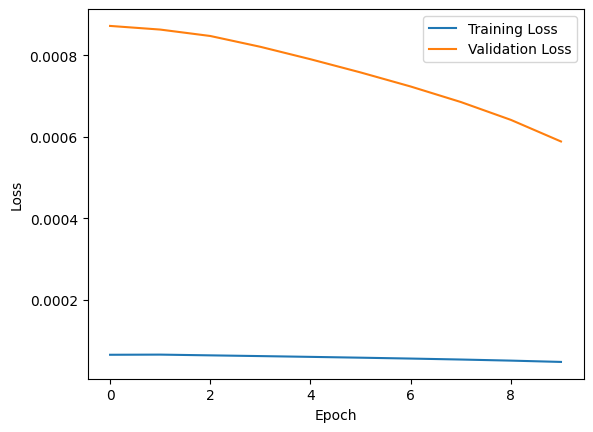

Test Loss: 0.001
***************************************************



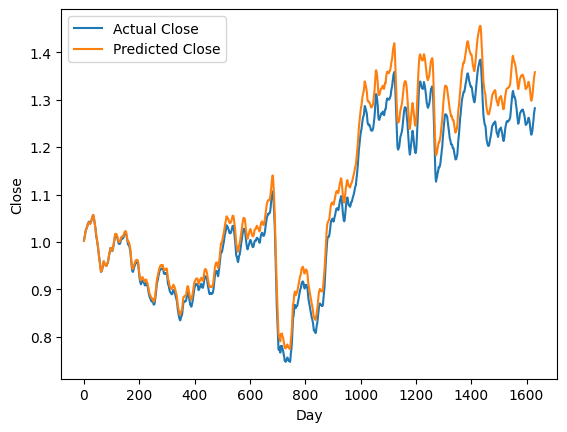

Test Set Metrics:
RMSE: 0.0425, MAE: 0.0353


In [852]:
def experiment_with_hyperparameters(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = LSTM(1, 8, 1)
    model.to(device)

    learning_rate = 0.001
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    hidden8_train_losses, hidden8_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    hidden8_new_y_test, hidden8_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return hidden8_train_losses, hidden8_val_losses, hidden8_new_y_test, hidden8_test_predictions

hidden8_train_losses, hidden8_val_losses, hidden8_new_y_test, hidden8_test_predictions = experiment_with_hyperparameters()

### **Hidden Size: 16**

Epoch: 1
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.010
Batch 300, Train Loss: 0.003
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Tr

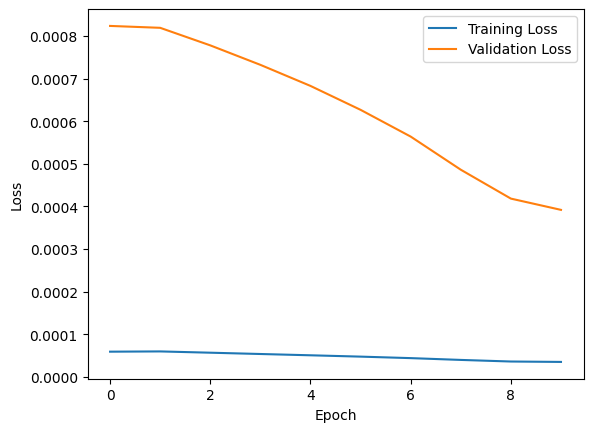

Test Loss: 0.001
***************************************************



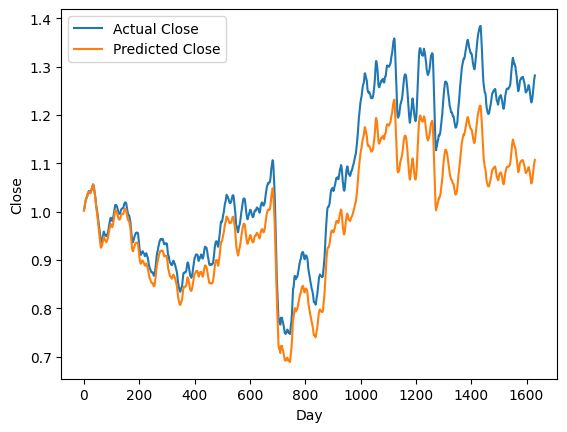

Test Set Metrics:
RMSE: 0.0974, MAE: 0.0816


In [853]:
def experiment_with_hyperparameters(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = LSTM(1, 16, 1)
    model.to(device)

    learning_rate = 0.001
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    hidden16_train_losses, hidden16_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    hidden16_new_y_test, hidden16_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return hidden16_train_losses, hidden16_val_losses, hidden16_new_y_test, hidden16_test_predictions

hidden16_train_losses, hidden16_val_losses, hidden16_new_y_test, hidden16_test_predictions = experiment_with_hyperparameters()

## **Plots of different Hidden Sizes**

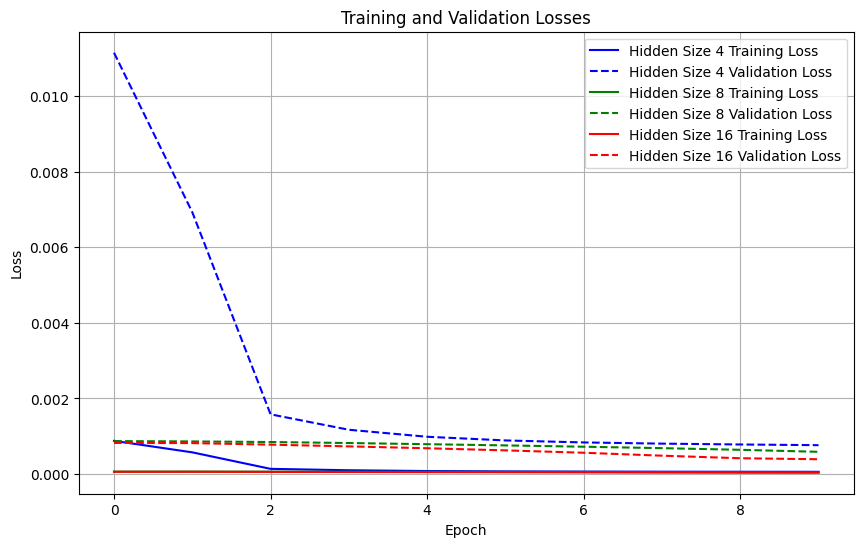

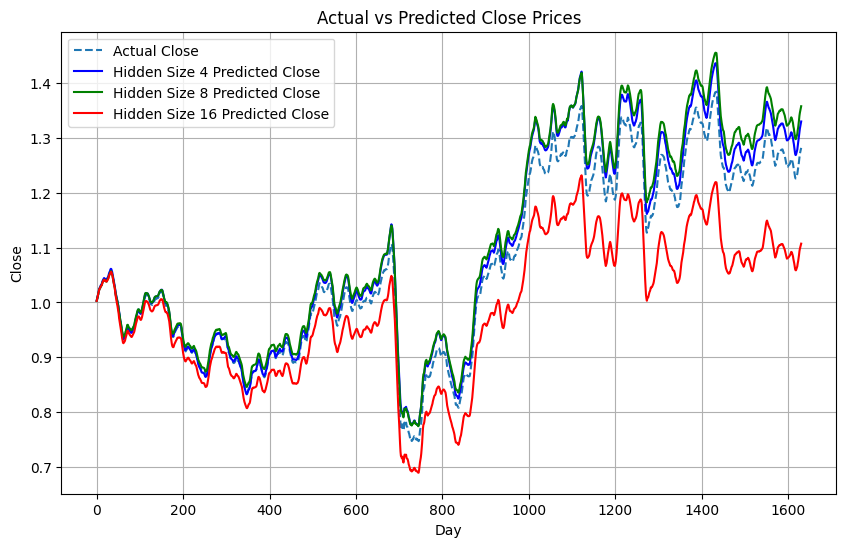

In [854]:
losses_train_list = [hidden4_train_losses, hidden8_train_losses, hidden16_train_losses]
losses_val_list = [hidden4_val_losses, hidden8_val_losses, hidden16_val_losses]
true_values = hidden16_new_y_test  # Use the true values that are common
predicted_values_lists = [hidden4_test_predictions, hidden8_test_predictions, hidden16_test_predictions]
titles = ['Hidden Size 4', 'Hidden Size 8', 'Hidden Size 16']

plot_losses(losses_train_list, losses_val_list, titles)
plot_predictions(true_values, predicted_values_lists, titles)

## **Experiment with different Numbers of Model Layers**

### **Numbers of Layers: 2**

### **Learning Rate: 0.001**

Epoch: 1
Batch 100, Train Loss: 0.059
Batch 200, Train Loss: 0.014
Batch 300, Train Loss: 0.026
Train Loss: 0.001, Val Loss: 0.011
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.013
Batch 300, Train Loss: 0.024
Train Loss: 0.001, Val Loss: 0.010
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.011
Batch 300, Train Loss: 0.018
Train Loss: 0.000, Val Loss: 0.004
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.003
Batch 300, Train Loss: 0.006
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.002
Batch 300, Train Loss: 0.004
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.002
Batch 300, Tr

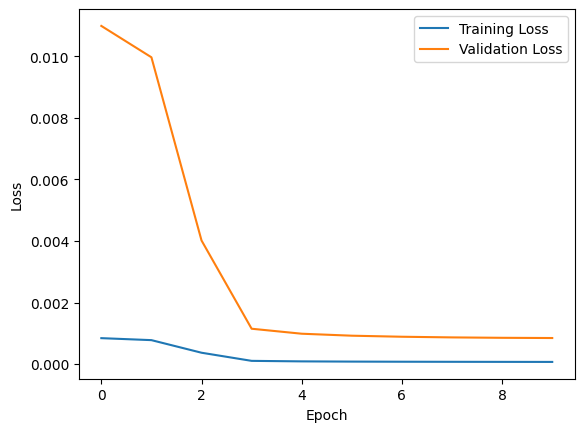

Test Loss: 0.002
***************************************************



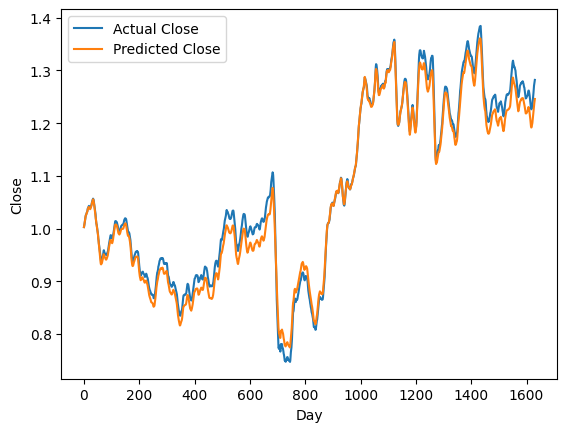

Test Set Metrics:
RMSE: 0.0194, MAE: 0.0163


In [855]:
def experiment_with_hyperparameters(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = LSTM(1, 4, 2)
    model.to(device)

    learning_rate = 0.001
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    layers2_train_losses, layers2_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    layers2_new_y_test, layers2_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return layers2_train_losses, layers2_val_losses, layers2_new_y_test, layers2_test_predictions

layers2_train_losses, layers2_val_losses, layers2_new_y_test, layers2_test_predictions = experiment_with_hyperparameters()

### **Numbers of Layers: 3**

Epoch: 1
Batch 100, Train Loss: 0.100
Batch 200, Train Loss: 0.014
Batch 300, Train Loss: 0.025
Train Loss: 0.001, Val Loss: 0.011
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.012
Batch 300, Train Loss: 0.017
Train Loss: 0.000, Val Loss: 0.003
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.003
Batch 300, Train Loss: 0.006
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.002
Batch 300, Train Loss: 0.005
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.002
Batch 300, Train Loss: 0.004
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.002
Batch 300, Tr

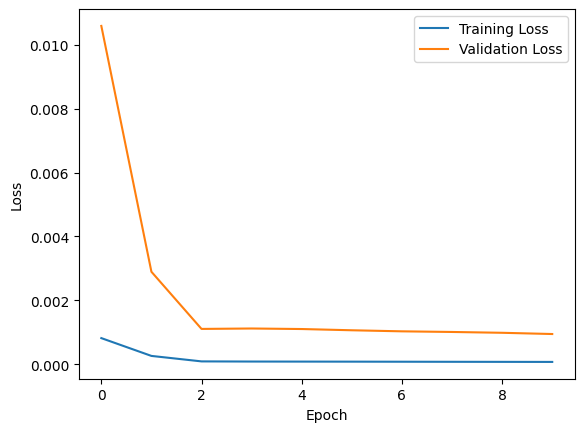

Test Loss: 0.001
***************************************************



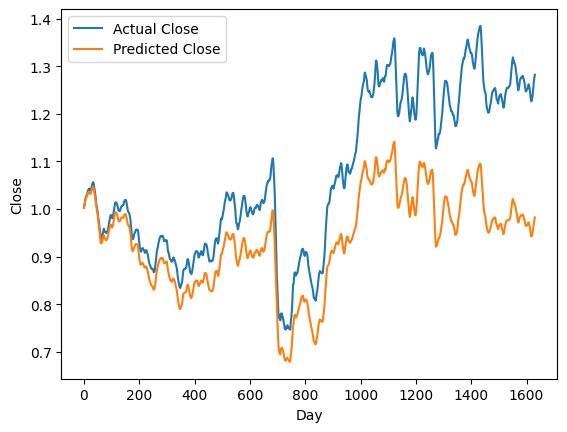

Test Set Metrics:
RMSE: 0.1631, MAE: 0.1354


In [856]:
def experiment_with_hyperparameters(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = LSTM(1, 4, 3)
    model.to(device)

    learning_rate = 0.001
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    layers3_train_losses, layers3_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    layers3_new_y_test, layers3_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return layers3_train_losses, layers3_val_losses, layers3_new_y_test, layers3_test_predictions

layers3_train_losses, layers3_val_losses, layers3_new_y_test, layers3_test_predictions = experiment_with_hyperparameters()

## **Plots of different Numbers of Layers**

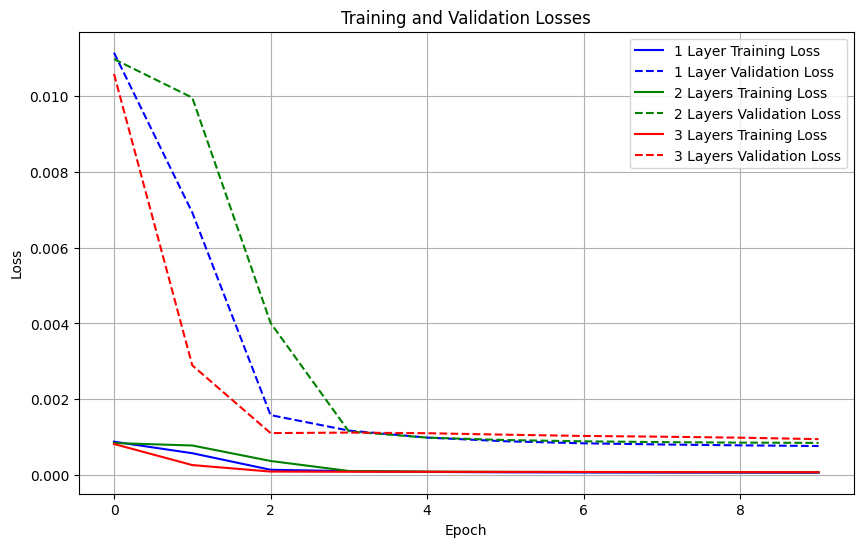

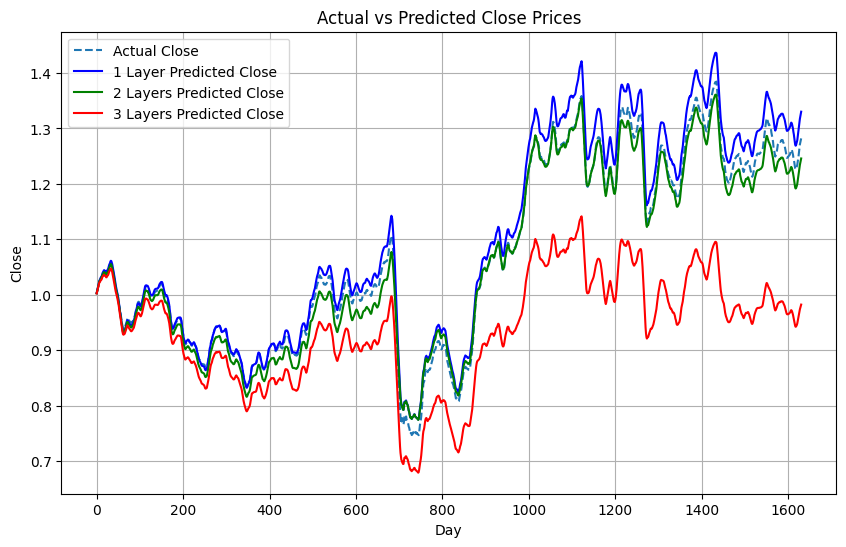

In [857]:
losses_train_list = [hidden4_train_losses, layers2_train_losses, layers3_train_losses]
losses_val_list = [hidden4_val_losses, layers2_val_losses, layers3_val_losses]
true_values = hidden16_new_y_test  # Use the true values that are common
predicted_values_lists = [hidden4_test_predictions, layers2_test_predictions, layers3_test_predictions]
titles = ['1 Layer', '2 Layers', '3 Layers']

plot_losses(losses_train_list, losses_val_list, titles)
plot_predictions(true_values, predicted_values_lists, titles)

## **Experiment with different Learning Rates**

### **Learning Rate: 0.1**

Epoch: 1
Batch 100, Train Loss: 0.001
Batch 200, Train Loss: 0.020
Batch 300, Train Loss: 0.034
Train Loss: 0.001, Val Loss: 0.012
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.014
Batch 300, Train Loss: 0.034
Train Loss: 0.001, Val Loss: 0.015
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.017
Batch 300, Train Loss: 0.033
Train Loss: 0.001, Val Loss: 0.015
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.017
Batch 300, Train Loss: 0.033
Train Loss: 0.001, Val Loss: 0.013
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.017
Batch 300, Train Loss: 0.033
Train Loss: 0.001, Val Loss: 0.016
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.017
Batch 300, Tr

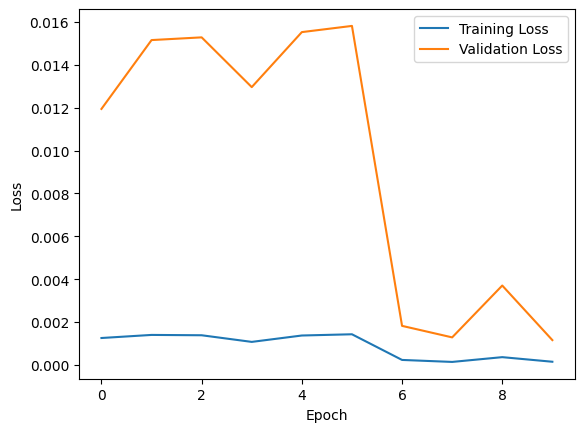

Test Loss: 0.002
***************************************************



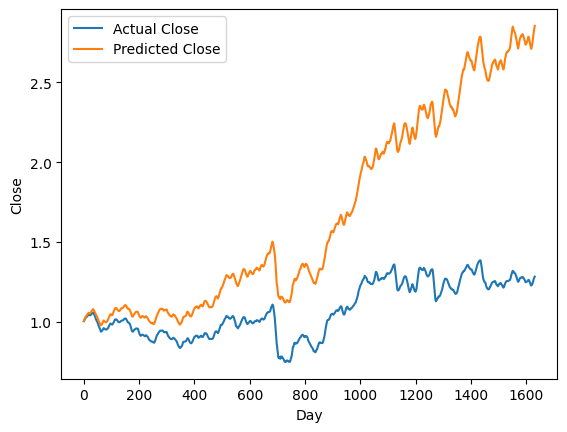

Test Set Metrics:
RMSE: 0.7673, MAE: 0.6036


In [870]:
def experiment_with_hyperparameters(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = LSTM(1, 4, 2)
    model.to(device)

    learning_rate = 0.1
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    lr01_train_losses, lr01_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    lr01_new_y_test, lr01_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return lr01_train_losses, lr01_val_losses, lr01_new_y_test, lr01_test_predictions

lr01_train_losses, lr01_val_losses, lr01_new_y_test, lr01_test_predictions = experiment_with_hyperparameters()

### **Learning Rate: 0.01**

Epoch: 1
Batch 100, Train Loss: 0.004
Batch 200, Train Loss: 0.014
Batch 300, Train Loss: 0.007
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.003
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.001
Train Loss: 0.000, Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.001
Train Loss: 0.000, Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Tr

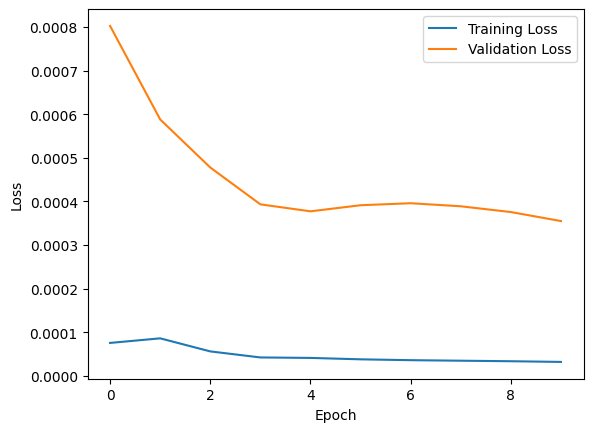

Test Loss: 0.001
***************************************************



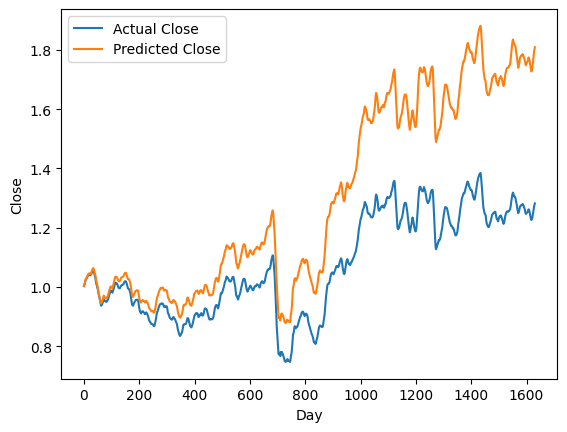

Test Set Metrics:
RMSE: 0.2800, MAE: 0.2259


In [859]:
def experiment_with_hyperparameters(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = LSTM(1, 4, 2)
    model.to(device)

    learning_rate = 0.01
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    lr001_train_losses, lr001_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    lr001_new_y_test, lr001_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return lr001_train_losses, lr001_val_losses, lr001_new_y_test, lr001_test_predictions

lr001_train_losses, lr001_val_losses, lr001_new_y_test, lr001_test_predictions = experiment_with_hyperparameters()

## **Plots of different Learning Rates**

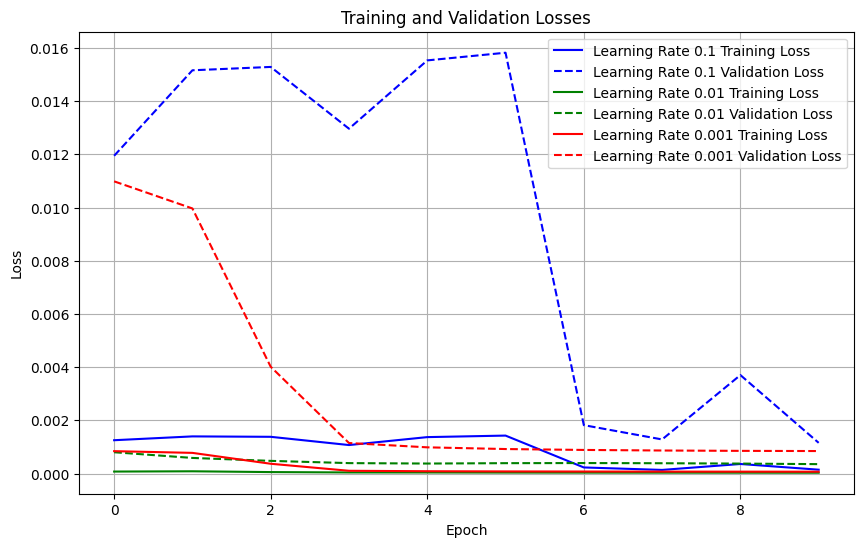

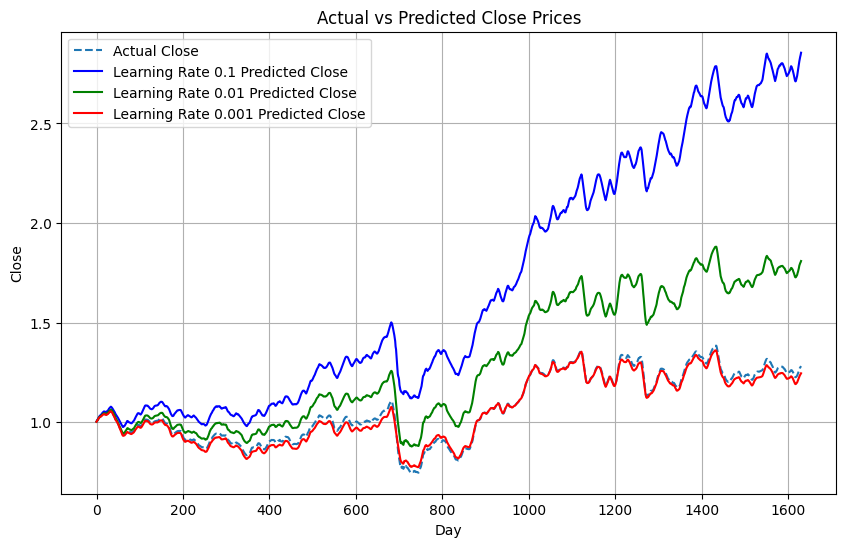

In [871]:
losses_train_list = [lr01_train_losses, lr001_train_losses, layers2_train_losses]
losses_val_list = [lr01_val_losses, lr001_val_losses, layers2_val_losses]
true_values = lr01_new_y_test  # Use the true values that are common
predicted_values_lists = [lr01_test_predictions, lr001_test_predictions, layers2_test_predictions]
titles = ['Learning Rate 0.1', 'Learning Rate 0.01', 'Learning Rate 0.001']

plot_losses(losses_train_list, losses_val_list, titles)
plot_predictions(true_values, predicted_values_lists, titles)

## **Experiment with different Optimizers**

### **Optimizer: SGD**

Epoch: 1
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.012
Batch 300, Train Loss: 0.021
Train Loss: 0.001, Val Loss: 0.007
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.008
Batch 300, Train Loss: 0.012
Train Loss: 0.000, Val Loss: 0.003
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.003
Batch 300, Train Loss: 0.004
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Tr

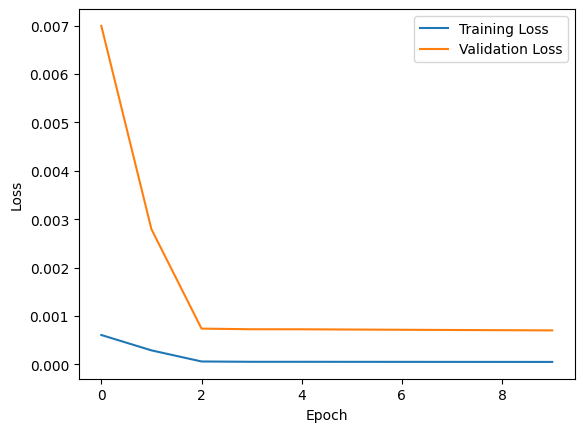

Test Loss: 0.001
***************************************************



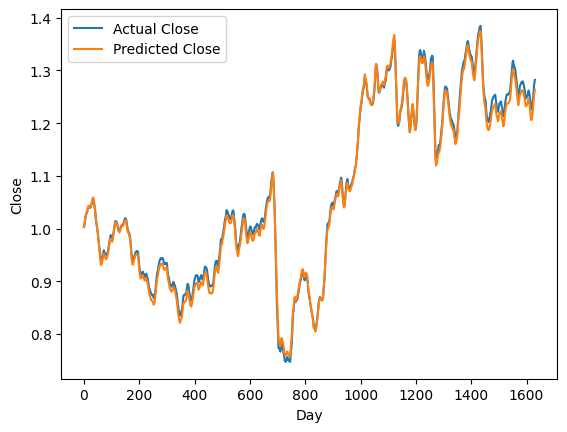

Test Set Metrics:
RMSE: 0.0099, MAE: 0.0085


In [874]:
def experiment_with_hyperparameters(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = LSTM(1, 4, 1)
    model.to(device)

    learning_rate = 0.01
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    sgd_train_losses, sgd_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    sgd_new_y_test, sgd_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return sgd_train_losses, sgd_val_losses, sgd_new_y_test, sgd_test_predictions

sgd_train_losses, sgd_val_losses, sgd_new_y_test, sgd_test_predictions = experiment_with_hyperparameters()

## **Plots of different Optimizers**

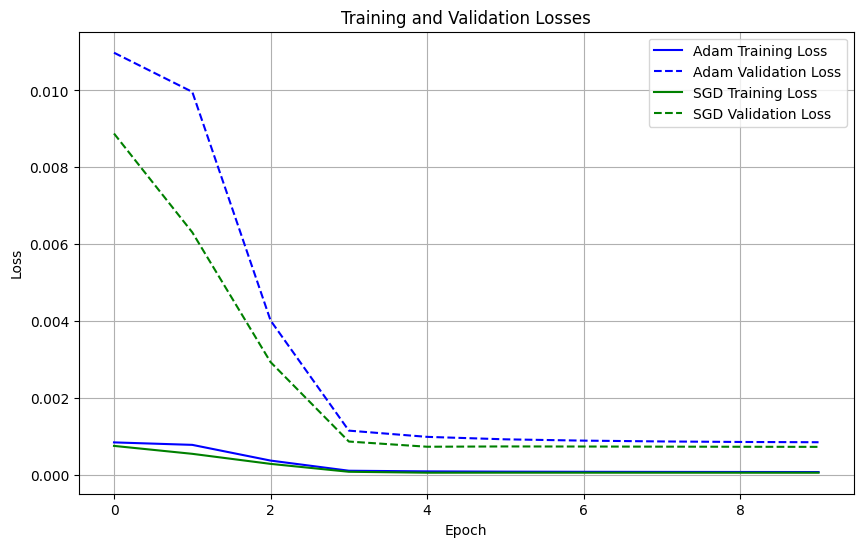

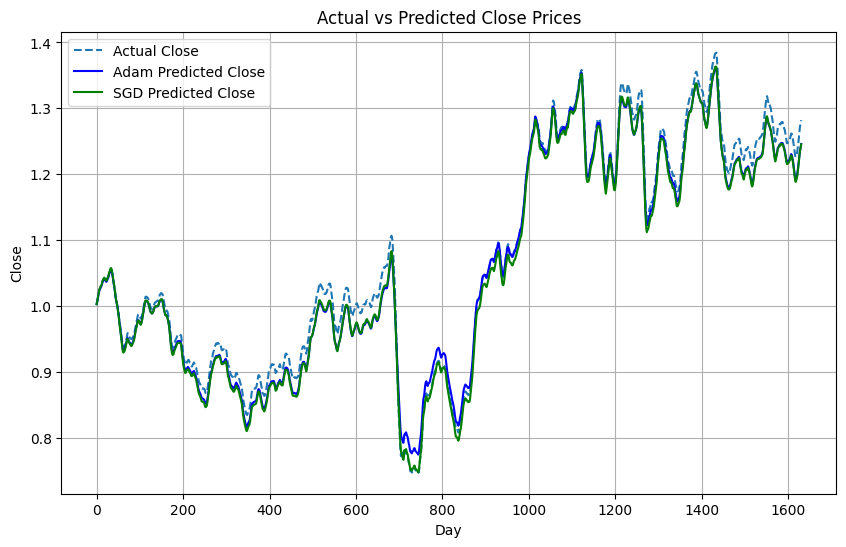

In [862]:
losses_train_list = [layers2_train_losses, sgd_train_losses]
losses_val_list = [layers2_val_losses, sgd_val_losses]
true_values = lr01_new_y_test  # Use the true values that are common
predicted_values_lists = [layers2_test_predictions, sgd_test_predictions]
titles = ['Adam', 'SGD']

plot_losses(losses_train_list, losses_val_list, titles)
plot_predictions(true_values, predicted_values_lists, titles)

# **Experiment with different Models**

## **Build RNN Model**

In [863]:
class RNN(nn.Module):
   def __init__(self, input_size, hidden_size, num_stacked_layers):
       super().__init__()
       self.hidden_size = hidden_size
       self.num_stacked_layers = num_stacked_layers
      
       # Define the RNN layer
       self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first=True)
      
       # Define a fully connected layer
       self.fc = nn.Linear(hidden_size, 1)
  
   def forward(self, x):
       batch_size = x.size(0)
       h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
      
       # Forward propagate RNN
       out, _ = self.rnn(x, h0)
      
       # Decode the hidden state of the last time step
       out = self.fc(out[:, -1, :])
       return out

Epoch: 1
Batch 100, Train Loss: 0.015
Batch 200, Train Loss: 0.014
Batch 300, Train Loss: 0.028
Train Loss: 0.001, Val Loss: 0.011
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.013
Batch 300, Train Loss: 0.026
Train Loss: 0.001, Val Loss: 0.010
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.012
Batch 300, Train Loss: 0.023
Train Loss: 0.001, Val Loss: 0.009
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.010
Batch 300, Train Loss: 0.019
Train Loss: 0.001, Val Loss: 0.007
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.008
Batch 300, Train Loss: 0.014
Train Loss: 0.000, Val Loss: 0.004
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.004
Batch 300, Tr

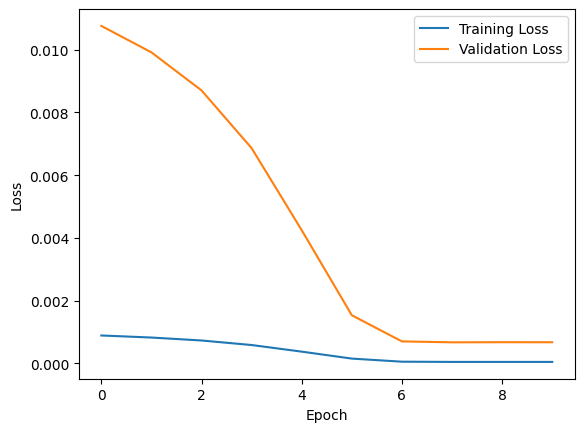

Test Loss: 0.001
***************************************************



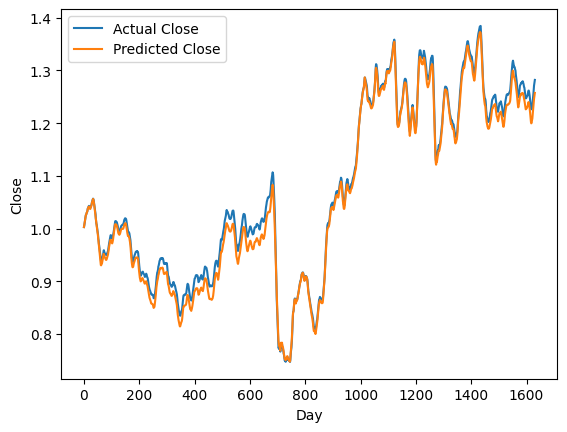

Test Set Metrics:
RMSE: 0.0154, MAE: 0.0129


In [864]:
def experiment_with_models(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = RNN(1, 16, 2)
    model.to(device)

    learning_rate = 0.001
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    rnn_train_losses, rnn_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    rnn_new_y_test, rnn_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return rnn_train_losses, rnn_val_losses, rnn_new_y_test, rnn_test_predictions

rnn_train_losses, rnn_val_losses, rnn_new_y_test, rnn_test_predictions = experiment_with_hyperparameters()

## **Build GRU Model**

In [865]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

Epoch: 1
Batch 100, Train Loss: 0.002
Batch 200, Train Loss: 0.010
Batch 300, Train Loss: 0.017
Train Loss: 0.000, Val Loss: 0.005
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.005
Batch 300, Train Loss: 0.007
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.003
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.002
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Tr

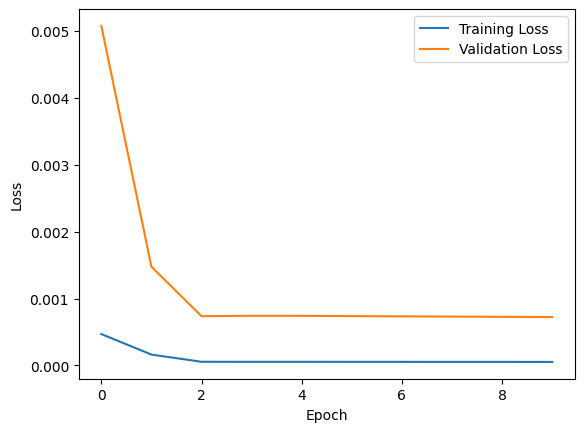

Test Loss: 0.001
***************************************************



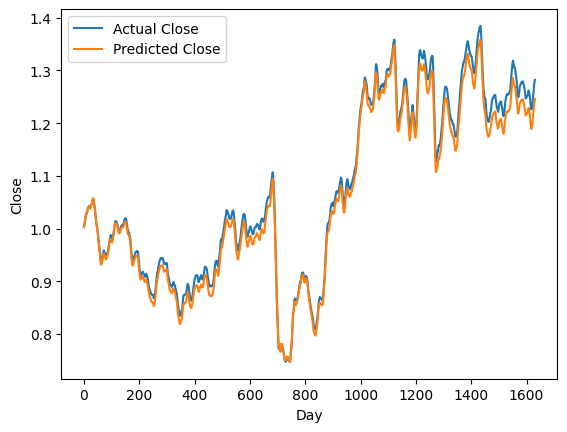

Test Set Metrics:
RMSE: 0.0183, MAE: 0.0160


In [866]:
def experiment_with_models(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = GRU(1, 16, 1)
    model.to(device)

    learning_rate = 0.001
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    gru_train_losses,  gru_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    gru_new_y_test,  gru_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return gru_train_losses,  gru_val_losses, gru_new_y_test,  gru_test_predictions

gru_train_losses,  gru_val_losses, gru_new_y_test,  gru_test_predictions = experiment_with_hyperparameters()

## **Build CNN-LSTM Model**

In [867]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, num_filters, kernel_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.num_filters = num_filters
        self.kernel_size = kernel_size

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        
        # LSTM layers
        self.lstm = nn.LSTM(num_filters, hidden_size, num_stacked_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # CNN forward pass
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, input_size, sequence_length)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Reshape for LSTM input
        x = x.permute(0, 2, 1)  # Reshape back to (batch_size, sequence_length, num_filters)

        # LSTM forward pass
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))

        # Fully connected layer
        out = self.fc(out[:, -1, :])
        return out

Epoch: 1
Batch 100, Train Loss: 0.005
Batch 200, Train Loss: 0.012
Batch 300, Train Loss: 0.021
Train Loss: 0.001, Val Loss: 0.006
***************************************************

Epoch: 2
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.006
Batch 300, Train Loss: 0.007
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.004
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.003
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Train Loss: 0.003
Train Loss: 0.000, Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Train Loss: 0.000
Batch 200, Train Loss: 0.001
Batch 300, Tr

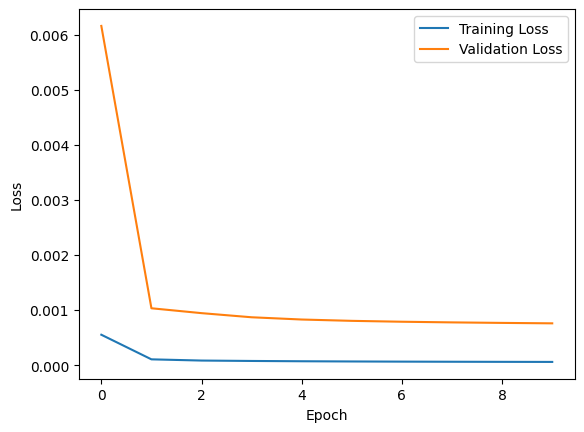

Test Loss: 0.001
***************************************************



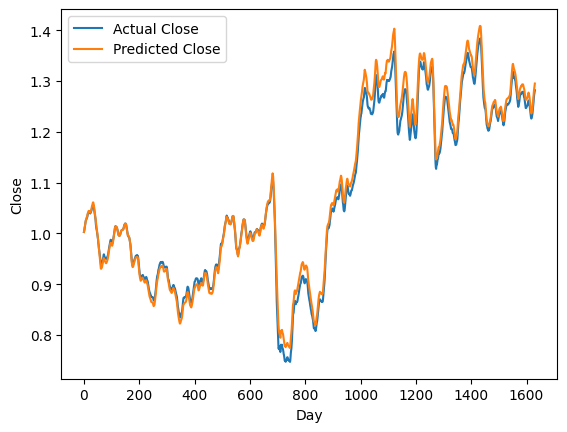

Test Set Metrics:
RMSE: 0.0178, MAE: 0.0143


In [868]:
def experiment_with_models(lookback=10, num_epochs=10, batch_size=16, learning_rate=0.001):

    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_dataset(CBA_preprocessed_data, lookback)
    train_loader = create_data_loader(X_train, y_train, batch_size=batch_size, shuffle=False)
    val_loader = create_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size=batch_size, shuffle=False)
        
    model = CNNLSTM(1, 4, 1, 16, 2)
    model.to(device)

    learning_rate = 0.001
    num_epochs = 10
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    cnnlstm_train_losses,  cnnlstm_val_losses = train_and_validate_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=num_epochs)
    cnnlstm_new_y_test,  cnnlstm_test_predictions = evaluate_model_on_test(model, test_loader, scaler, loss_function, X_test, y_test)

    return cnnlstm_train_losses,  cnnlstm_val_losses, cnnlstm_new_y_test,  cnnlstm_test_predictions

cnnlstm_train_losses,  cnnlstm_val_losses, cnnlstm_new_y_test,  cnnlstm_test_predictions = experiment_with_hyperparameters()

## **Plots of different Models**

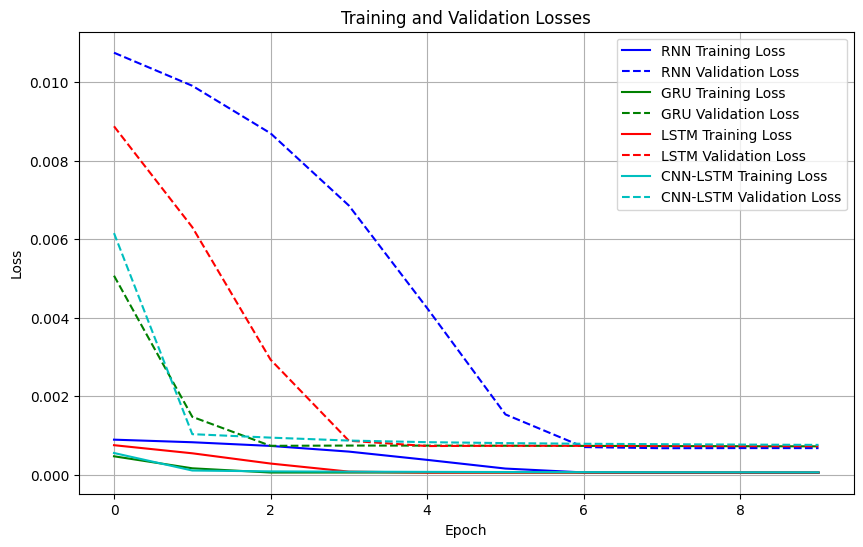

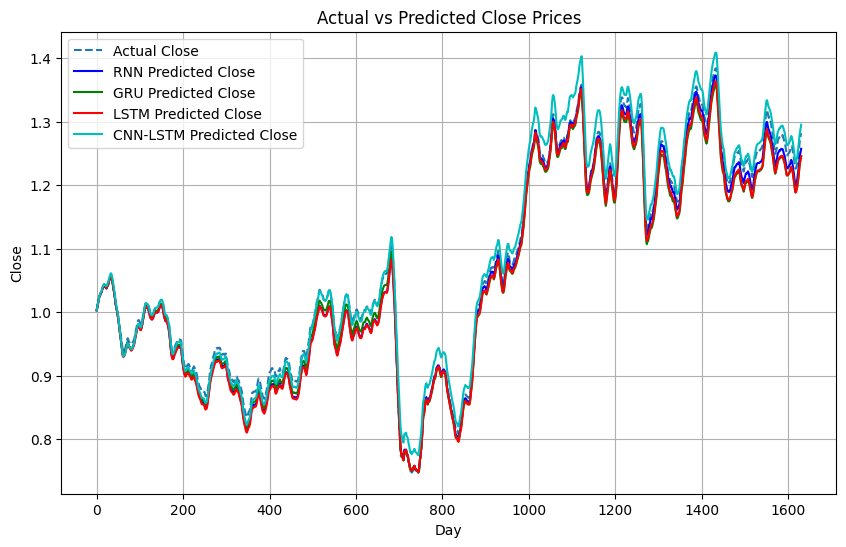

In [869]:
losses_train_list = [rnn_train_losses, gru_train_losses, sgd_train_losses, cnnlstm_train_losses]
losses_val_list = [rnn_val_losses, gru_val_losses, sgd_val_losses, cnnlstm_val_losses]
true_values = lr01_new_y_test  # Use the true values that are common
predicted_values_lists = [rnn_test_predictions, gru_test_predictions, sgd_test_predictions, cnnlstm_test_predictions]
titles = ['RNN', 'GRU', 'LSTM', 'CNN-LSTM']

plot_losses(losses_train_list, losses_val_list, titles)
plot_predictions(true_values, predicted_values_lists, titles)